In [ ]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
import graphviz
from datetime import timedelta
import io
import pandas as pd


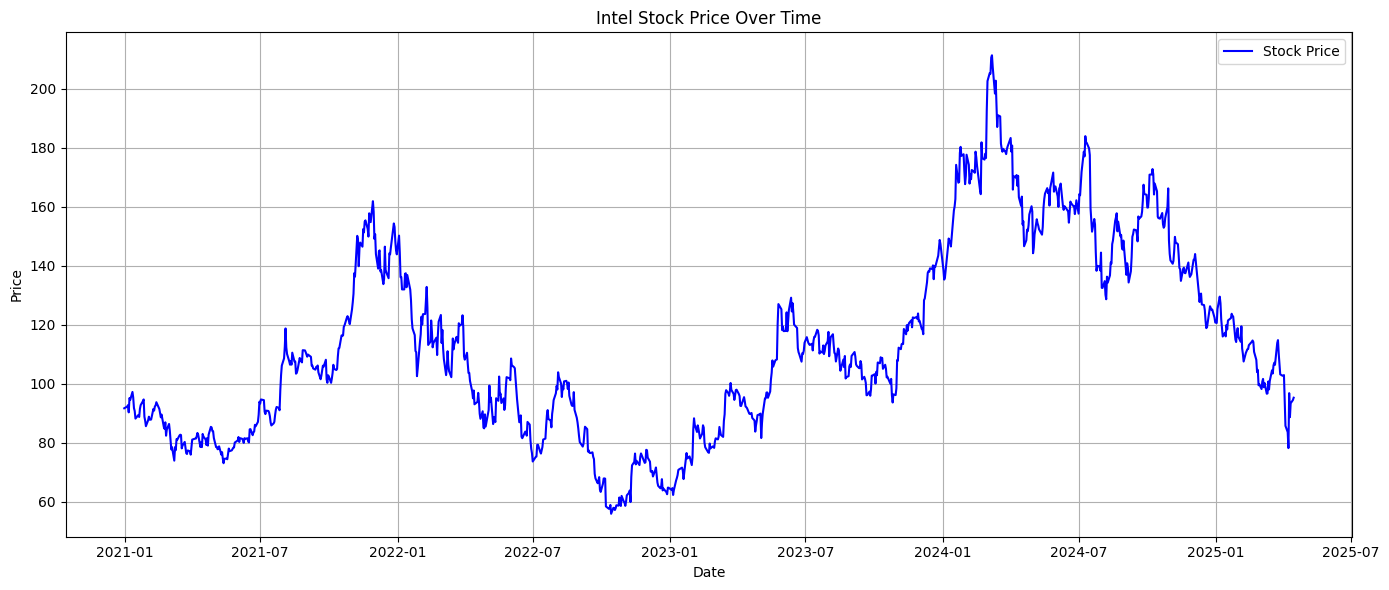

In [2]:
# Step 1: Load and Preprocess Data
# Load the dataset
df = pd.read_csv('C:/Users/Hp/IS403.P23_Nhom3/Dataset/amd_stock_price.csv')

# Clean and format columns
df.columns = ['date', 'price', 'open', 'high', 'low', 'volume', 'change_percent']
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Clean volume: remove 'M' and convert to float
df['volume'] = df['volume'].replace({'M': 'e6'}, regex=True).astype(float)

# Clean change_percent: remove '%' and convert to float
df['change_percent'] = df['change_percent'].str.replace('%', '').astype(float)

# Sort by date in ascending order
df = df.sort_values('date')

# Visualize raw stock price data
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['price'], label='Stock Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Intel Stock Price Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# Step 2: Feature Engineering
# Create features using a lookback window of 5 days
lookback = 5
X = []
y = []

for i in range(lookback, len(df)):
    X.append(df['price'].iloc[i-lookback:i].values)
    y.append(df['price'].iloc[i])

X = np.array(X)
y = np.array(y)

In [4]:
# Step 3: Split and Scale Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

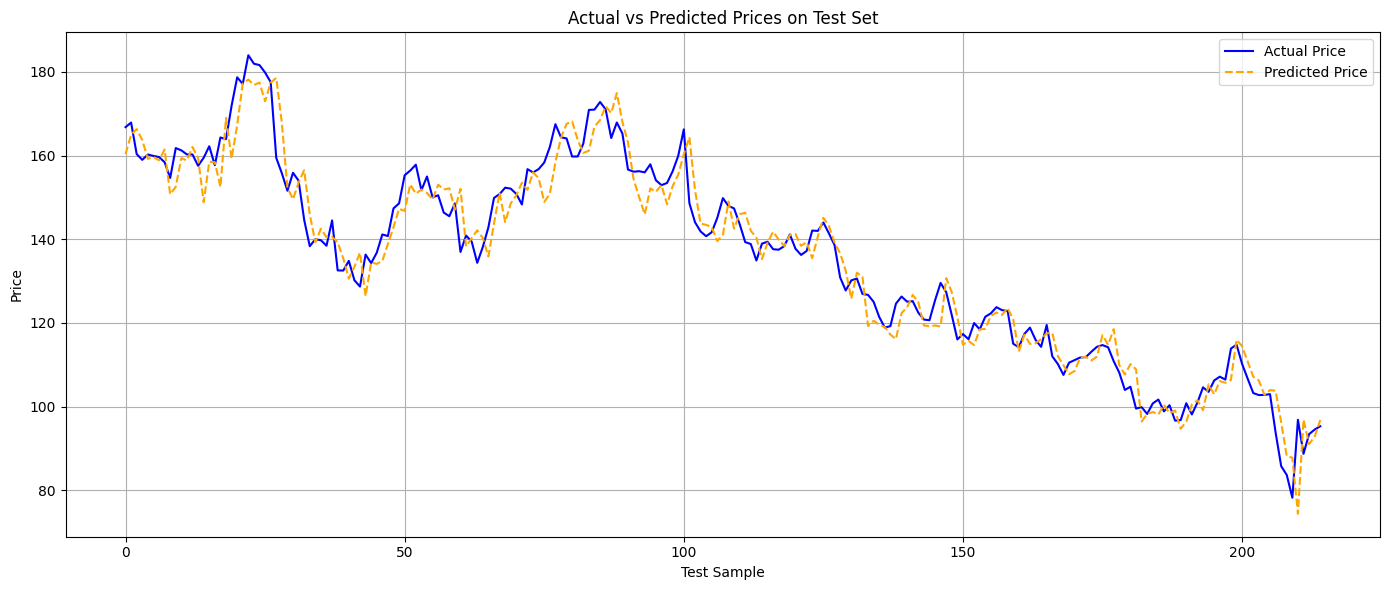

In [5]:
# Step 4: Train Gradient Boosting Model
model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate model on test set
y_pred = model.predict(X_test_scaled)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange', linestyle='--')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Step 6: Predict Future Prices (30 and 60 Days)
future_preds_30 = []
future_preds_60 = []

# Start with the last 5 days
last_known = df['price'].iloc[-lookback:].values

# Predict 30 days
current_input = last_known.copy()
for _ in range(30):
    input_scaled = scaler.transform([current_input])
    next_price = model.predict(input_scaled)[0]
    future_preds_30.append(next_price)
    current_input = np.append(current_input[1:], next_price)

# Predict 60 days
current_input = last_known.copy()
for _ in range(60):
    input_scaled = scaler.transform([current_input])
    next_price = model.predict(input_scaled)[0]
    future_preds_60.append(next_price)
    current_input = np.append(current_input[1:], next_price)

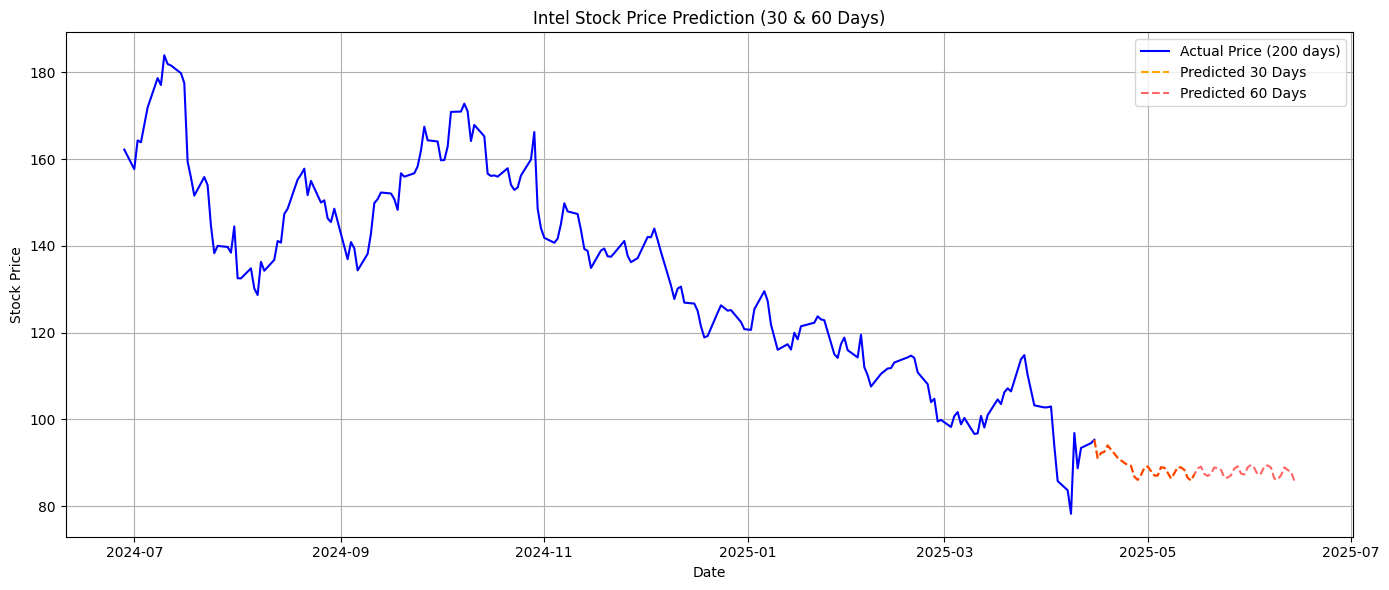

In [7]:
# Step 7: Visualize Predictions
last_date = df['date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 61)]
price_recent = df.iloc[-200:].copy()

plt.figure(figsize=(14, 6))
plt.plot(price_recent['date'], price_recent['price'], label='Actual Price (200 days)', color='blue')
future_preds_30_plot = [price_recent['price'].iloc[-1]] + future_preds_30
future_dates_30_plot = [price_recent['date'].iloc[-1]] + future_dates[:30]
plt.plot(future_dates_30_plot, future_preds_30_plot, label='Predicted 30 Days', linestyle='--', color='orange')
future_preds_60_plot = [price_recent['price'].iloc[-1]] + future_preds_60
future_dates_60_plot = [price_recent['date'].iloc[-1]] + future_dates
plt.plot(future_dates_60_plot, future_preds_60_plot, label='Predicted 60 Days', linestyle='--', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Intel Stock Price Prediction (30 & 60 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()